In [23]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file (e.g. pd.read_csv)

In [4]:
df = pd.read_csv(r"C:\Users\furka\Desktop\ain4311\project\real-time-motion-detector\data\geophone-sensor-data.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      1800 non-null   object 
 1   mean           1800 non-null   float64
 2   top_3_mean     1800 non-null   float64
 3   min            1800 non-null   int64  
 4   max            1800 non-null   int64  
 5   std_dev        1800 non-null   float64
 6   median         1800 non-null   float64
 7   q1             1800 non-null   float64
 8   q3             1800 non-null   float64
 9   skewness       1800 non-null   float64
 10  dominant_freq  1800 non-null   float64
 11  energy         1800 non-null   float64
 12  activity       1800 non-null   object 
 13  name           1800 non-null   object 
dtypes: float64(9), int64(2), object(3)
memory usage: 197.0+ KB


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [10]:
def plot_feature_distributions(df, features):
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(x='activity', y=feature, data=df)
        plt.xticks(rotation=45)
        plt.title(f'{feature} by Activity')
    plt.tight_layout()
    return plt

In [11]:
def plot_correlation_matrix(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    return plt

In [20]:
def train_random_forest_cl(df):
    
    model_dir = "../models/"
    
    features = ['mean', 'top_3_mean', 'min', 'max', 'std_dev', 'median', 
                'q1', 'q3', 'skewness', 'dominant_freq', 'energy']
    
    X = df[features]
    y = df['activity']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    y_pred = rf.predict(X_test_scaled)
    
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Modelin kaydedileceği dizini kontrol et ve oluştur
    existing_versions = [int(i) for i in os.listdir(model_dir) if i.isdigit()]
    model_version = max(existing_versions, default=0) + 1
    model_version_dir = f"{model_dir}/{model_version}"
    os.makedirs(model_version_dir, exist_ok=True)
    
    # Modeli kaydet
    model_path = f"{model_version_dir}/Random_forest_classifier.joblib"
    joblib.dump(rf, model_path)
    
    # Modelin değerlendirilmesi
    test_accuracy = rf.score(X_test_scaled, y_test)
    
    return {
        'model': rf,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': feature_importance,
        'test_accuracy': test_accuracy,
        'model_path': model_path  # Modelin kaydedildiği yolu da döndür
    }

In [21]:
def main():
    # Perform EDA
    features_to_plot = ['mean', 'std_dev', 'dominant_freq', 'energy']
    dist_plot = plot_feature_distributions(df, features_to_plot)
    dist_plot.savefig('feature_distributions.png')
    
    corr_plot = plot_correlation_matrix(df)
    corr_plot.savefig('correlation_matrix.png')
    
    # Train and evaluate model
    results = train_random_forest_cl(df)
    
    # Print results
    print("Model Performance:")
    print("-----------------")
    print("\nClassification Report:")
    print(results['classification_report'])
    
    print("\nTop 5 Important Features:")
    print(results['feature_importance'].head())
    
    print(f"\nModel Test Accuracy: {results['test_accuracy']:.2%}")

Model Performance:
-----------------

Classification Report:
              precision    recall  f1-score   support

     running       0.85      0.89      0.87       105
     waiting       0.86      0.89      0.88       128
     walking       0.90      0.83      0.87       127

    accuracy                           0.87       360
   macro avg       0.87      0.87      0.87       360
weighted avg       0.87      0.87      0.87       360


Top 5 Important Features:
      feature  importance
4     std_dev    0.149411
3         max    0.143101
1  top_3_mean    0.117379
0        mean    0.110716
2         min    0.102931

Model Test Accuracy: 86.94%


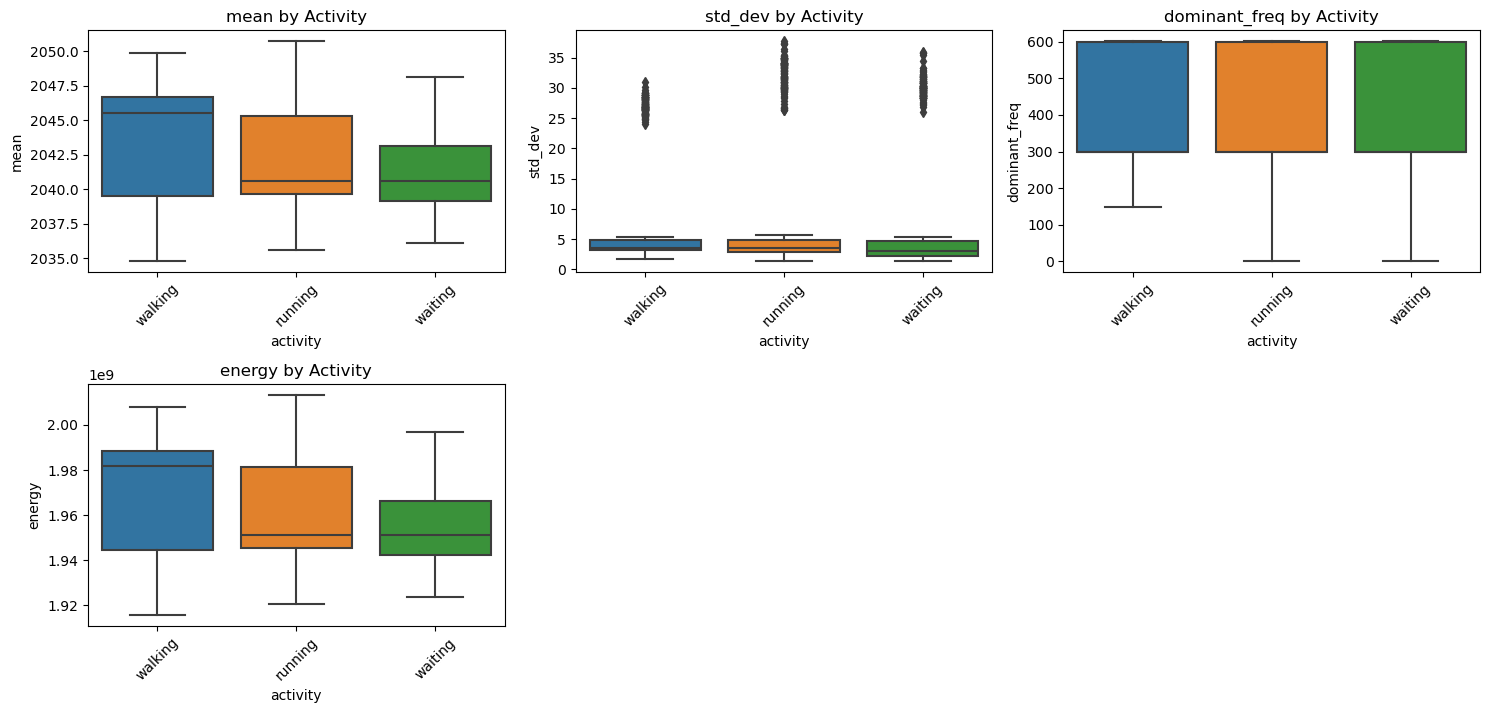

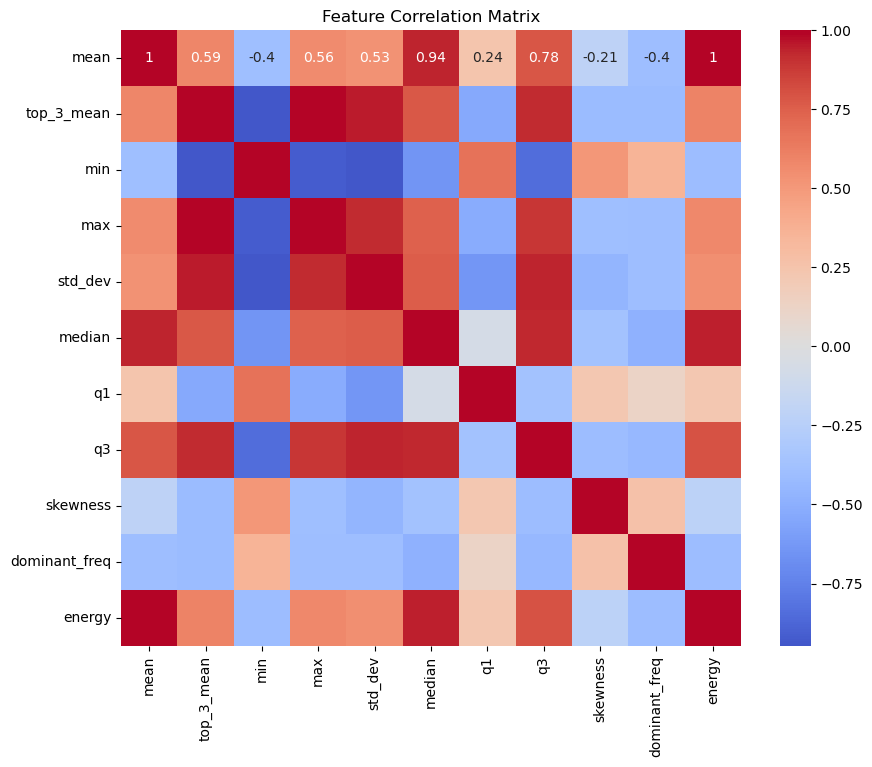

In [24]:
if __name__ == "__main__":
    main()